In [182]:
import pandas as pd
import numpy as np
import os,cv2
from skimage import io,color
import matplotlib.pyplot as plt

In [183]:
data=pd.read_csv("metadata_agroaid.csv")
data.head()

,crop,disease,count,path
0,potato,early blight,1001,/Users/pragadeeswarrs/Desktop/AgroAid/potato/P...
1,potato,late blight,1001,/Users/pragadeeswarrs/Desktop/AgroAid/potato/P...
2,potato,healthy,153,/Users/pragadeeswarrs/Desktop/AgroAid/potato/P...
3,corn,common rust,1307,/Users/pragadeeswarrs/Desktop/AgroAid/Corn/Com...
4,corn,gray leaf,575,/Users/pragadeeswarrs/Desktop/AgroAid/Corn/Gra...


In [184]:
data['path']=data['path'].str.replace("'",'',regex=False)
data['disease']=data['disease'].str.lower()
data['crop']=data['crop'].str.lower()
data.head()

,crop,disease,count,path
0,potato,early blight,1001,/Users/pragadeeswarrs/Desktop/AgroAid/potato/P...
1,potato,late blight,1001,/Users/pragadeeswarrs/Desktop/AgroAid/potato/P...
2,potato,healthy,153,/Users/pragadeeswarrs/Desktop/AgroAid/potato/P...
3,corn,common rust,1307,/Users/pragadeeswarrs/Desktop/AgroAid/Corn/Com...
4,corn,gray leaf,575,/Users/pragadeeswarrs/Desktop/AgroAid/Corn/Gra...


In [185]:
base="/Users/pragadeeswarrs/Desktop/AgroAid/data"
folders = [f for f in os.listdir(base) if not f.startswith('.')]
crops=folders
images=[]
labels=[]

In [186]:
for crop in crops:
    crop_folder=os.path.join(base,crop) #pathname of crop folder
    diseases=[f for f in os.listdir(crop_folder) if not f.startswith('.')]#taking the list disease in each crop
    for d in diseases:
        disease_folder=os.path.join(crop_folder,d)#making pathname of disease folder
        for file in os.listdir(disease_folder): #goin through imgs in respective diseases
            if file.startswith('.'):
                continue
            img_path=os.path.join(disease_folder,file)
            img=cv2.imread(img_path)
            if img is not None:
                img=cv2.resize(img,(128,128))
                img=img/255.0
                images.append(img)
                labels.append(f"{crop}_{d}")

In [187]:
images=np.array(images)
labels=np.array(labels)


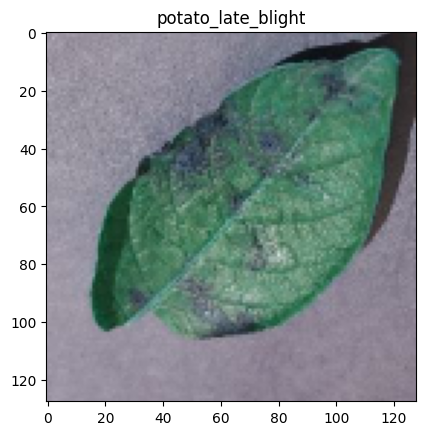

In [188]:
plt.imshow(images[0])
plt.title(labels[0])
plt.show()


In [189]:
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops

In [190]:
x_train,x_test,y_train,y_test=train_test_split(
    images,labels,test_size=0.2,random_state=42,stratify=labels
)

In [191]:
x_train.shape
feature_list=[]
feature_labels=[]

## Feature Extraction

In [192]:
for i,img in enumerate(x_train):
    mean_r=np.mean(img[:,:,0])
    mean_b=np.mean(img[:,:,1])
    mean_g=np.mean(img[:,:,2])
    std_r=np.std(img[:,:,0])
    std_b=np.std(img[:,:,1])
    std_g=np.std(img[:,:,2])
    color_features=[mean_r,mean_b,mean_g,std_r,std_b,std_g]
    gray=(img*255.0).astype(np.uint8)
    gray=np.mean(gray,axis=2).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast=graycoprops(glcm,'contrast')[0,0]
    homogeneity=graycoprops(glcm,'homogeneity')[0,0]
    texture_features=[contrast,homogeneity]
    features=color_features+texture_features
    feature_list.append(features)
    feature_labels.append(y_train[i])


In [193]:
x_features=np.array(feature_list)
y_features=np.array(feature_labels)
x_features.shape

(7649, 8)

In [194]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier

## Crop classifier

In [195]:
y_crop=[label.split('_')[0]for label in y_features]
rf_crop=RandomForestClassifier(n_estimators=100,random_state=42)
rf_crop.fit(x_features,y_crop)
test_feature=[]
for i, img in enumerate(x_test):
    # Color features
    mean_r = np.mean(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
    std_r = np.std(img[:,:,0])
    std_g = np.std(img[:,:,1])
    std_b = np.std(img[:,:,2])
    color_features = [mean_r, mean_g, mean_b, std_r, std_g, std_b]

    # Texture features
    gray = (img * 255).astype(np.uint8)
    gray = np.mean(gray, axis=2).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    texture_features = [contrast, homogeneity]

    # Combine features
    features = color_features + texture_features
    test_feature.append(features)

x_test_features = np.array(test_feature)


In [196]:
y_crop_test = [label.split('_')[0] for label in y_test]
y_crop_pred = rf_crop.predict(x_test_features)
print("Crop Classification Accuracy:", accuracy_score(y_crop_test, y_crop_pred))



Crop Classification Accuracy: 0.9309984317825405


In [197]:
print("Crop Classification Report:\n", classification_report(y_crop_test, y_crop_pred))


Crop Classification Report:
               precision    recall  f1-score   support

        corn       0.97      0.94      0.96       609
      potato       0.89      0.86      0.87       430
      tomato       0.92      0.96      0.94       874

    accuracy                           0.93      1913
   macro avg       0.93      0.92      0.92      1913
weighted avg       0.93      0.93      0.93      1913



## Disease Classifier

In [198]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Function to train and test disease classifier for one crop
def train_disease_classifier(crop_name):
    # --- filter training data for this crop ---
    X_crop = np.array([
        x_features[i] for i, label in enumerate(y_train)
        if label.split('_')[0] == crop_name
    ])
    y_crop_disease = [
        '_'.join(label.split('_')[1:])  # join remaining parts to form full disease name
        for i, label in enumerate(y_train)
        if label.split('_')[0] == crop_name
    ]

    # filter test data for this crop 
    X_test_crop = np.array([
        x_test_features[i] for i, label in enumerate(y_test)
        if label.split('_')[0] == crop_name
    ])
    y_test_crop = [
        '_'.join(label.split('_')[1:])  # same joining for test labels
        for i, label in enumerate(y_test)
        if label.split('_')[0] == crop_name
    ]

   

    # train model
    rf_disease = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_disease.fit(X_crop, y_crop_disease)

    #  predict and evaluate
    y_pred_disease = rf_disease.predict(X_test_crop)
    print(f"\nDisease Classification Report for {crop_name.upper()}:")
    print(classification_report(y_test_crop, y_pred_disease))
    print("-" * 60)
    return rf_disease

# run the function for each crop in your dataset

rf_disease_dict = {}
for crop in sorted(set([label.split('_')[0] for label in y_train])):
    rf_disease_dict[crop] = train_disease_classifier(crop)  #maintains a dictionary of crops and their respective disease



Disease Classification Report for CORN:
                precision    recall  f1-score   support

   common_rust       0.96      0.95      0.96       261
gray_leaf_spot       0.90      0.78      0.84       115
       healthy       0.91      0.98      0.94       233

      accuracy                           0.93       609
     macro avg       0.92      0.91      0.91       609
  weighted avg       0.93      0.93      0.93       609

------------------------------------------------------------

Disease Classification Report for POTATO:
              precision    recall  f1-score   support

early_blight       0.92      0.93      0.92       200
     healthy       1.00      0.53      0.70        30
 late_blight       0.89      0.94      0.91       200

    accuracy                           0.90       430
   macro avg       0.93      0.80      0.84       430
weighted avg       0.91      0.90      0.90       430

------------------------------------------------------------

Disease Classific

# Combining models and finding disease using pathname

In [199]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def predict_crop_and_disease_jupyter(img_path):


   
    img_path = img_path.strip().replace("'", "").replace('"', '')  # remove extra quotes/spaces

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None, None

    #  Read and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image (corrupt or unsupported): {img_path}")
        return None, None

    img = cv2.resize(img, (128, 128))
    img = img / 255.0

    #  Feature extraction
    mean_r, mean_g, mean_b = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
    std_r, std_g, std_b = np.std(img[:,:,0]), np.std(img[:,:,1]), np.std(img[:,:,2])
    color_features = [mean_r, mean_g, mean_b, std_r, std_g, std_b]

    gray = (img * 255).astype(np.uint8)
    gray = np.mean(gray, axis=2).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    texture_features = [contrast, homogeneity]

    features = np.array(color_features + texture_features).reshape(1, -1)

    # Predict crop
    crop_pred = rf_crop.predict(features)[0]

    #  Predict disease
    if crop_pred in rf_disease_dict:
        disease_pred = rf_disease_dict[crop_pred].predict(features)[0]
    else:
        disease_pred = None

    return crop_pred, disease_pred


saving the models as pickle file,so it can be accessed separetly

In [200]:
import joblib
joblib.dump(rf_crop, "rf_crop.pkl")
joblib.dump(rf_disease_dict, "rf_disease_dict.pkl")


['rf_disease_dict.pkl']